In [1]:
import sys
import math
import matplotlib.pyplot as plt
import cv2
sys.path.append('../')

from scripts.point_cloud_utils import send_point_cloud
from pyngp.common import *
from tqdm import tqdm
import pyngp.pyngp as ngp
from  scripts.ros_utils import get_image_tf_pair, send_tf



In [2]:
width = 854
height = 480
spp = 1 # 1 is fast 8 is default

objects = ['table', 'truck', 'block']
testbed_map = {}
for obj in objects:
    testbed = ngp.Testbed()
    testbed.load_snapshot(f'../nerf/{obj}.ingp')
    testbed_map[obj] = testbed
def srgb_to_linear(img):
    limit = 0.04045
    return np.where(img > limit, np.power((img + 0.055) / 1.055, 2.4), img / 12.92)

def linear_to_srgb(img):
    limit = 0.0031308
    return np.where(img > limit, 1.055 * (img ** (1.0 / 2.4)) - 0.055, 12.92 * img)

camera_matrix = testbed_map['table'].camera_matrix


14:30:46 SUCCESS  Initialized CUDA 12.0. Active GPU is #0: NVIDIA GeForce RTX 4090 [89]
14:30:46 INFO     Loading network snapshot from: ../nerf/table.ingp
14:30:49 DEBUG    GPUMemory: allocating 1.41 KB.
14:30:49 DEBUG    GPUMemory: allocating 144 B.
14:30:49 DEBUG    GPUMemory: allocating 144 B.
14:30:49 DEBUG    GPUMemory: allocating 144 B.
14:30:49 DEBUG    GPUMemory: allocating 144 B.
14:30:49 DEBUG    GPUMemory: allocating 8 B.
14:30:49 DEBUG    GPUMemory: allocating 1.12 KB.
14:30:49 DEBUG    GPUMemory: allocating 4 MB.
14:30:49 DEBUG    GPUMemory: allocating 8 MB.
14:30:49 DEBUG    GPUMemory: allocating 2 MB.
14:30:49 DEBUG    GPUMemory: allocating 64 KB.
14:30:49 INFO     GridEncoding:  Nmin=16 b=2 F=4 T=2^22 L=8
14:30:49 DEBUG    GridEncoding at level 0: resolution=16 params_in_level=4096
14:30:49 DEBUG    GridEncoding at level 1: resolution=32 params_in_level=32768
14:30:49 DEBUG    GridEncoding at level 2: resolution=64 params_in_level=262144
14:30:49 DEBUG    GridEncoding 

In [3]:
ros_image, tf = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
tf = tf[0]
ros_image = ros_image[0]

c2w = tf.copy()
c2w[0:3, 2] *= -1  # flip the y and z axis
c2w[0:3, 1] *= -1
c2w = c2w[[1, 0, 2, 3], :]
c2w[2, :] *= -1  # flip whole world upside down
tf_ngp = c2w
tf_ngp = tf_ngp[:-1, :]

testbed.set_nerf_camera_matrix(tf_ngp)
camera_matrix2 = testbed.camera_matrix.copy()

depth_buffer = 10000000*np.ones((height, width))
image_composed = np.zeros((height, width, 3))



for obj in objects:
    testbed = testbed_map[obj]
    camera_matrix_tmp = camera_matrix2.copy()
    if obj != 'table':
        tmp = (.2*(np.random.rand(3, 1)-.5) ).squeeze()
        tmp[2] = 0
        camera_matrix_tmp[:, -1] = camera_matrix_tmp[:, -1] + camera_matrix_tmp[:, :3] @ tmp
    testbed.camera_matrix = camera_matrix_tmp
    testbed.nerf.render_min_transmittance = 0.01
    testbed.render_mode = ngp.RenderMode.Shade
    testbed.color_space = ngp.ColorSpace.Linear
    image = testbed.render(width, height, spp, True)
    testbed.nerf.render_min_transmittance = 0.9
    testbed.render_mode = ngp.RenderMode.Depth
    depth = testbed.render(width, height, spp, True)
    depth = depth[:,:,0]
    inds = (depth < depth_buffer) * (depth > 0.2)
    image_composed[inds, 0] = image[inds, 0]
    image_composed[inds, 1] = image[inds, 1]
    image_composed[inds, 2] = image[inds, 2]
    depth_buffer[inds] = depth[inds]

image_composed = linear_to_srgb(image_composed)


14:31:02 DEBUG    GPUMemory: allocating 6.25 MB.
14:31:02 DEBUG    GPUMemory: allocating 1.56 MB.
14:31:02 DEBUG    GPUMemory: allocating 6.25 MB.
14:31:02 DEBUG    GPUMemoryArena: enlarging from 0 B to 258 MB
14:31:02 DEBUG    GPUMemoryArena: enlarging from 260 MB to 383 MB
14:31:02 DEBUG    GPUMemoryArena: enlarging from 384 MB to 508 MB
14:31:02 DEBUG    GPUMemory: allocating 6.25 MB.
14:31:02 DEBUG    GPUMemory: allocating 1.56 MB.
14:31:02 DEBUG    GPUMemory: allocating 6.25 MB.
14:31:02 DEBUG    GPUMemoryArena: enlarging from 0 B to 258 MB
14:31:02 DEBUG    GPUMemoryArena: enlarging from 260 MB to 271 MB
14:31:02 DEBUG    GPUMemoryArena: enlarging from 272 MB to 285 MB
14:31:02 DEBUG    GPUMemory: allocating 6.25 MB.
14:31:02 DEBUG    GPUMemory: allocating 1.56 MB.
14:31:02 DEBUG    GPUMemory: allocating 6.25 MB.
14:31:02 DEBUG    GPUMemoryArena: enlarging from 0 B to 258 MB


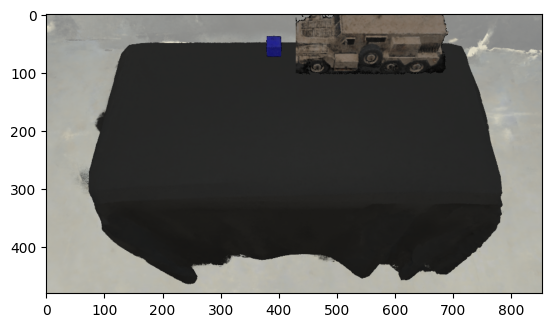

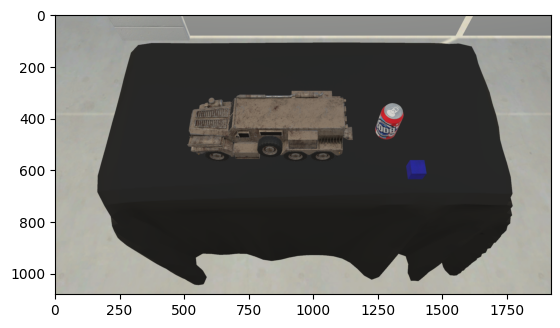

In [4]:
plt.figure()
plt.imshow(image_composed)
plt.figure()
plt.imshow(ros_image)

scale = 1.0
image_composed = cv2.resize(image_composed, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
ros_image = cv2.resize(ros_image, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC) 
tmp = np.max(depth_buffer)
depth_buffer = tmp*cv2.resize(depth_buffer/tmp, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR) 

In [5]:
sys.path.append('../unimatch_repo')

import torch
import torch.nn.functional as F
from unimatch.unimatch import UniMatch
from evaluate_flow import inference_flow
from utils.flow_viz import flow_to_image
from PIL import Image as im

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UniMatch(feature_channels=128,
                 num_scales=2,
                 upsample_factor=4,
                 num_head=1,
                 ffn_dim_expansion=4,
                 num_transformer_layers=6,
                 reg_refine=True,
                 task='flow').to(device)

trained_model_path = '../unimatch_repo/pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth'
loc = 'cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(trained_model_path, map_location=loc)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

UniMatch(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
    

In [6]:
import sys
sys.path.append('../unimatch_repo')
import torch
import torch.nn.functional as F
from unimatch.unimatch import UniMatch
from dataloader.stereo import transforms
from utils.visualization import viz_depth_tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_stereo = UniMatch(feature_channels=128,
                 num_scales=2,
                 upsample_factor=4,
                 num_head=1,
                 ffn_dim_expansion=4,
                 num_transformer_layers=6,
                 reg_refine=True,
                 task='stereo').to(device)

trained_depth_path = '../unimatch_repo/pretrained/gmstereo-scale2-regrefine3-resumeflowthings-middleburyfthighres-a82bec03.pth'
loc = 'cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(trained_depth_path, map_location=loc)
model_stereo.load_state_dict(checkpoint['model'], strict=False)
model_stereo.eval()

UniMatch(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
    

0.12461185455322266


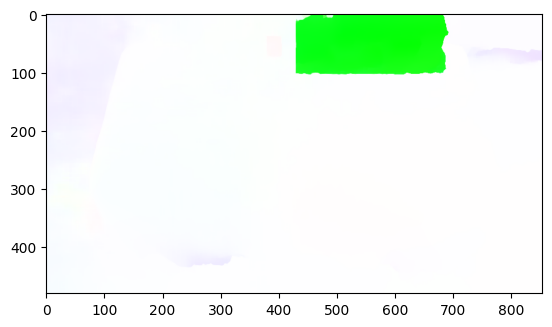

In [9]:

def get_flow(model, image1, image2): 
    padding_factor=32

    # the model is trained with size: width > height
    transpose_img = False
    if image1.size(-2) > image1.size(-1):
        image1 = torch.transpose(image1, -2, -1)
        image2 = torch.transpose(image2, -2, -1)
        transpose_img = True

    nearest_size = [int(np.ceil(image1.size(-2) / padding_factor)) * padding_factor,
                    int(np.ceil(image1.size(-1) / padding_factor)) * padding_factor]
    fixed_inference_size = None
    # fixed_inference_size = [val//2 for val in nearest_size] 
#     fixed_inference_size = (224, 384)

    # resize to nearest size or specified size
    inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

    assert isinstance(inference_size, list) or isinstance(inference_size, tuple)
    ori_size = image1.shape[-2:]

    # resize before inference
    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        image1 = F.interpolate(image1, size=inference_size, mode='bilinear',
                               align_corners=True)
        image2 = F.interpolate(image2, size=inference_size, mode='bilinear',
                               align_corners=True)


    for i in range(1):
        import time
        start = time.time()
        with torch.inference_mode():
            results_dict = model(image1, image2,
                                attn_type='swin',
                                attn_splits_list=[2, 8],
                                corr_radius_list=[-1, 4],
                                prop_radius_list=[-1, 1],
                                num_reg_refine=6,
                                task='flow'
                                )
        print(time.time() - start)


    flow_pr = results_dict['flow_preds'][-1]

    # resize back
    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        flow_pr = F.interpolate(flow_pr, size=ori_size, mode='nearest') # align_corners=True
        flow_pr[:, 0] = flow_pr[:, 0] * ori_size[-1] / inference_size[-1]
        flow_pr[:, 1] = flow_pr[:, 1] * ori_size[-2] / inference_size[-2]

    if transpose_img:
        flow_pr = torch.transpose(flow_pr, -2, -1)

    flow = flow_pr[0].permute(1, 2, 0).cpu().numpy()  # [H, W, 2]
    return flow 


image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
image2 = ros_image[:,:,:3]
image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)

flow = get_flow(model, image1, image2)
    
plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def get_points(depth, tf_cam_world_inv, fov, width, height):
    fx = 2*np.tan(fov/2.0)
    fy = fx*width/height
    Z = depth
    [Xgrid, Ygrid] = np.meshgrid(np.linspace(-.5, .5, width), np.linspace(-.5, .5, height))
    X = (Xgrid)*Z/fx
    Y = (Ygrid)*Z/fy
    points = np.stack([X, Y, Z], axis=2);
    points = np.reshape(points, (-1, 3))
    points = (points @ tf_cam_world_inv[:3, :3].transpose()) + np.reshape(tf_cam_world_inv[:3, 3], (1, 3))
    
    return points

cached_render = {}
def render_nerf(testbed_map, tf_map, fov, width, height):
    all_points = []
    all_depth = []
    depth_buffer = 10000000*np.ones((height, width))
    image_composed = np.zeros((height, width, 3))
    object_inds = np.zeros((height, width), dtype=np.int32)
    
    
    for ind, obj in enumerate(testbed_map):
        testbed = testbed_map[obj]
        tf_nerf_cam = tf_map[obj]
        tf_cam_nerf = np.linalg.inv(tf_nerf_cam.detach().cpu().numpy())
        c2w = tf_cam_nerf.copy()
        c2w[0:3, 2] *= -1  # flip the y and z axis
        c2w[0:3, 1] *= -1
        c2w = c2w[[1, 0, 2, 3], :]
        c2w[2, :] *= -1  # flip whole world upside down
        tf_ngp = c2w
        tf_ngp = tf_ngp[:-1, :]
        testbed.set_nerf_camera_matrix(tf_ngp)

        if obj == 'table' and obj in cached_render:
            image, depth = cached_render[obj]
        else:
            testbed.nerf.render_min_transmittance = 0.01
            testbed.render_mode = ngp.RenderMode.Shade
            testbed.color_space = ngp.ColorSpace.Linear
            image = testbed.render(width, height, spp, True)
            testbed.nerf.render_min_transmittance = 0.9
            testbed.render_mode = ngp.RenderMode.Depth
            depth = testbed.render(width, height, spp, True)
        
        if obj == 'table' and obj not in cached_render:
            cached_render[obj] = (image, depth)
            
        depth = depth[:, :, 0]
        depth[depth < 0.1]  = 10000000
        inds = (depth < depth_buffer)
        image_composed[inds, 0] = image[inds, 0]
        image_composed[inds, 1] = image[inds, 1]
        image_composed[inds, 2] = image[inds, 2]
        depth_buffer[inds] = depth[inds]
        object_inds[inds] = ind
        
        all_depth.append(depth.flatten())
        points = get_points(depth, tf_cam_nerf, fov, width, height) 
        Rt_tensor = tf_nerf_cam[:3, :3].transpose(0, 1)
        p_tensor = tf_nerf_cam[:3, 3]
        points = torch.tensor(points, dtype=torch.float32, device='cuda', requires_grad=False)
        points_tensor = (points @ Rt_tensor) + torch.reshape(p_tensor, (1, 3)) # need grad
        all_points.append(points_tensor)
        
        
    all_points = torch.stack(all_points, axis=0)
    all_depth = torch.tensor(np.vstack(all_depth), dtype=torch.float32, device='cuda')
    min_z, inds = torch.min(all_depth, axis=0) # keepdim=True 
    
    x_vals = all_points[:, :, 0].flatten()
    y_vals = all_points[:, :, 1].flatten()
    z_vals = all_points[:, :, 2].flatten()
    
    inds = inds*inds.shape[0] + torch.linspace(0, inds.shape[0]-1, inds.shape[0], dtype=torch.int32, device='cuda')
    
    points_composed = torch.stack([x_vals[inds], y_vals[inds], z_vals[inds]], axis=1)
    image_composed = linear_to_srgb(image_composed)
    
    return points_composed, image_composed, object_inds  



def get_transform(rpy_params, xyz_params):
    rpy_params = torch.reshape(rpy_params, (3,1))
    xyz_params = torch.reshape(xyz_params, (3,1)) 
    ct = torch.cos(rpy_params);
    st = torch.sin(rpy_params);
    R00 = ct[0]*ct[2]*ct[1] - st[0]*st[2]
    R01 = -ct[0]*ct[1]*st[2] - st[0]*ct[2]
    R02 = ct[0]*st[1]
    R10 = st[0]*ct[2]*ct[1] + ct[0]*st[2]
    R11 = -st[0]*ct[1]*st[2] + ct[0]*ct[2]
    R12 = st[0]*st[1]
    R20 = -st[1]*ct[2]
    R21 = st[1]*st[2]
    R22 = ct[1]
    R0 = torch.hstack([R00, R01, R02])
    R1 = torch.hstack([R10, R11, R12])
    R2 = torch.hstack([R20, R21, R22])
    R = torch.stack([R0, R1, R2], axis=0);
        
    row = torch.tensor([[0.0, 0.0, 0.0, 1.0]], dtype=torch.float32, device='cuda')
    M = torch.hstack([R, xyz_params])
    T = torch.vstack([M, row])
    return T

class CorrespondenceNet(nn.Module):
    def __init__(self, testbed_map, width, height, tf):
        super(CorrespondenceNet, self).__init__()
        self.testbed_map = testbed_map
        self.width = width
        self.height = height
        self.objects = [key for key in testbed_map.keys() ]
#         tmp = 2*3.14*torch.rand(3*len(self.objects), dtype=torch.float32, device='cuda')
#         tmp[0::3] = 0
#         tmp[1::3] = 0
#         self.rpy = nn.Parameter(tmp)
#         tmp = .25 - .5*torch.rand(3*len(self.objects), dtype=torch.float32, device='cuda')
#         tmp[2::3] = 0
#         self.xyz = nn.Parameter(tmp)
        self.fov = testbed_map['table'].fov
        assert all([testbed_map[key].fov == self.fov for key in testbed_map])
        self.fov = math.pi*self.fov/180.0
        self.tf_cam_world = torch.tensor(tf, dtype=torch.float32, device='cuda') 
        self.default_transforms = {}
        self.tf_nerf_cam = {}
        
        
        for obj in self.objects:
            T = np.linalg.inv(tf)
            self.default_transforms[obj] = torch.tensor(T, dtype=torch.float32, device='cuda')
        for obj in self.objects:
            self.reset_transform(obj)
        
        
    def reset_transform(self, obj):
        if obj == 'table':
            self.tf_nerf_cam[obj] = self.default_transforms[obj]
            return
                
        box_tf = np.eye(4,4, dtype=np.float32)
        box_tf[:3, 3] = self.testbed_map[obj].crop_box()[:3, 3]
        box_tf[[0,1], 3] = box_tf[[1,0], 3]
        xyz = .25 - .5*torch.rand(3, dtype=torch.float32, device='cuda')
        xyz[2::3] = 0
        tf_trans_learned = get_transform(torch.zeros(3).to(device), xyz)
        rpy = 2*3.14*torch.rand(3, dtype=torch.float32, device='cuda')
        rpy[0::3] = 0
        rpy[1::3] = 0
        tf_rot_learned = get_transform(rpy, torch.zeros(3).to(device))
        box_tf_inv = torch.from_numpy(np.linalg.inv(box_tf)).to(device)
        box_tf = torch.from_numpy(box_tf).to(device)

        default_transform = torch.tensor([[-1.0000, 0.0000, 0.0000,  0],
                                        [ 0.0000,  1.0, 0, 0],
                                        [-0.0000, 0, -1.0,  0],
                                        [ 0.0000,  0.0000,  0.0000,  1.0000]]).to(device)
        default_transform[0,3] += box_tf[0,3]
        default_transform[1,3] += box_tf[1,3]
        default_transform[2,3] += box_tf[2,3] + 0.8
        default_transform = torch.linalg.inv(default_transform)

        tf_nerf_cam =  default_transform @ (box_tf @ tf_rot_learned  @ box_tf_inv) 
        tf_nerf_cam = tf_trans_learned @ tf_nerf_cam
        self.tf_nerf_cam[obj] = tf_nerf_cam 
                
        
    def forward(self):
        tf_map = {}
        ind = 0
        for obj in self.objects:
#             default_transform = self.default_transforms[obj]
#             if obj != 'table':
#                 box_tf = np.eye(4,4, dtype=np.float32)
#                 box_tf[:3, 3] = self.testbed_map[obj].crop_box()[:3, 3]
#                 box_tf[[0,1], 3] = box_tf[[1,0], 3]
                
#                 tf_trans_learned = get_transform(torch.zeros(3).to(device), self.xyz[(ind)*3:(ind+1)*3])
#                 tf_rot_learned = get_transform(self.rpy[(ind)*3:(ind+1)*3], torch.zeros(3).to(device))
#                 box_tf_inv = torch.from_numpy(np.linalg.inv(box_tf)).to(device)
#                 box_tf = torch.from_numpy(box_tf).to(device)
                
#                 default_transform = torch.tensor([[-1.0000, 0.0000, 0.0000,  0],
#                                                 [ 0.0000,  1.0, 0, 0],
#                                                 [-0.0000, 0, -1.0,  0],
#                                                 [ 0.0000,  0.0000,  0.0000,  1.0000]]).to(device)
#                 default_transform[0,3] += box_tf[0,3]
#                 default_transform[1,3] += box_tf[1,3]
#                 default_transform[2,3] += box_tf[2,3] + 0.8
#                 default_transform = torch.linalg.inv(default_transform)

#                 tf_nerf_cam =  default_transform @ (box_tf @ tf_rot_learned  @ box_tf_inv) 
#                 tf_nerf_cam = tf_trans_learned @ tf_nerf_cam
                
#                 ind += 1
#             else:
#                 tf_nerf_cam = default_transform
            tf_map[obj] = self.tf_nerf_cam[obj]
            
        points_composed, image_composed, object_inds = render_nerf(self.testbed_map, tf_map, self.fov, self.width, self.height)
        
        Rt = self.tf_cam_world[:3, :3].transpose(0,1)
        points_composed_world = (points_composed @ Rt) + torch.reshape(self.tf_cam_world[:3, 3], (1, 3)) 
        x = points_composed[:, 0]/points_composed[:, 2];
        y = points_composed[:, 1]/points_composed[:, 2];
        points_2d = torch.stack([x, y], axis=1)
        
        return points_composed, points_composed_world, points_2d, image_composed, object_inds

def compute_loss(pred_points, target_points, uv, target_grid):
    loss = F.huber_loss(pred_points, target_points)
    return loss
    
ros_image, tf = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
ros_image = ros_image[0]
tf = tf[0]
network = CorrespondenceNet(testbed_map, width, height, tf)
network.cuda(device='cuda')



[WARN] [1695580276.071465205] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


CorrespondenceNet()

14:31:17 DEBUG    GPUMemoryArena: enlarging from 286 MB to 296 MB


[WARN] [1695580277.320187799] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


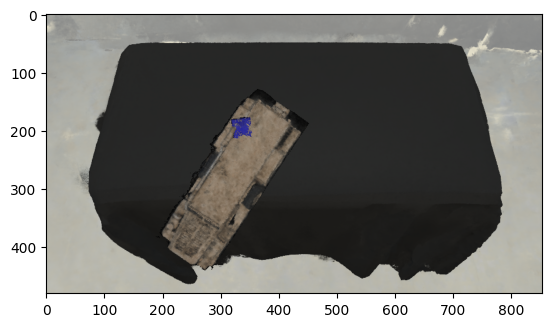

In [11]:
points_composed, points_composed_world, points_2d, image_composed, object_inds = network()
plt.figure()
plt.imshow(image_composed)
colors = np.reshape(image_composed, (-1, 3))
colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
send_point_cloud(np.hstack((points_composed_world.detach().cpu().numpy(), colors)), has_alpha=False)

# tmp = np.ones(points_composed_world.shape)
# tmp[:, :2] = points_2d.detach().cpu().numpy()
# send_point_cloud(np.hstack((tmp, colors)), has_alpha=False, topic='point_cloud_2')
# print(torch.max(points_2d))

0.11649894714355469


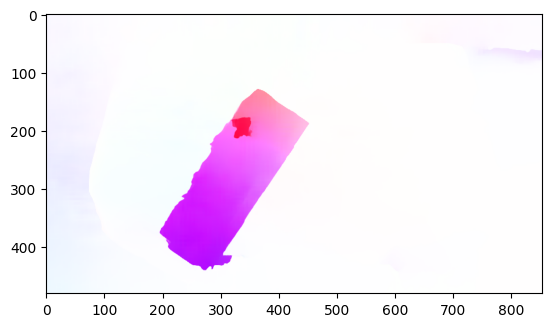

In [12]:
image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
image2 = ros_image[:,:,:3]
image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)

flow = get_flow(model, image1, image2)

plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

[WARN] [1695580279.425442583] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]


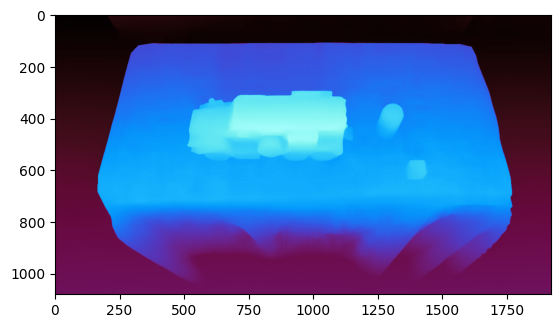

In [13]:
from utils.visualization import vis_disparity

def get_disparity(model_stereo, left, right):
    padding_factor = 32
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]


    sample = {'left': left,
              'right': right
              }
    val_transform_list = [transforms.ToTensor(), transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)]
    val_transform = transforms.Compose(val_transform_list)
    sample = val_transform(sample)
    left = sample['left'].to(device).unsqueeze(0)  # [1, 3, H, W]
    right = sample['right'].to(device).unsqueeze(0)  # [1, 3, H, W]

    nearest_size = [int(np.ceil(left.size(-2) / padding_factor)) * padding_factor,
                    int(np.ceil(left.size(-1) / padding_factor)) * padding_factor]

    fixed_inference_size = [val//2 for val in nearest_size] 
    print(fixed_inference_size)
#     fixed_inference_size = [288, 480]
#     fixed_inference_size = None

    # resize to nearest size or specified size
    inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

    ori_size = left.shape[-2:]

    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        left = F.interpolate(left, size=inference_size,
                             mode='bilinear',
                             align_corners=True)
        right = F.interpolate(right, size=inference_size,
                              mode='bilinear',
                                  align_corners=True)

    with torch.no_grad():
        import time
        for i  in range(1):
            start = time.time()
            pred_disp = model_stereo(left, right,
                               attn_type='self_swin2d_cross_swin1d',
                               attn_splits_list=[2, 8],
                               prop_radius_list=[-1, 1],
                               corr_radius_list=[-1, 4],
                               num_reg_refine=3,
                               task='stereo',
                               )['flow_preds'][-1]  # [1, H, W]
#             print(time.time() - start)



    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        pred_disp = F.interpolate(pred_disp.unsqueeze(1), size=ori_size, mode='nearest').squeeze(1)  # [1, H, W]


    disp = pred_disp[0].cpu().numpy()
    return disp 



left, left_pose = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
left_pose = left_pose[0]
left = left[0]

right, right_pose = get_image_tf_pair(image_topics=['camera_image_r'], tf_names=['camera_frame_r'])
right_pose = right_pose[0]
right = right[0]



left = left[:,:,:3].astype(np.float32)
left_ori = left.copy() 
right = right[:,:,:3].astype(np.float32)

disp = get_disparity(model_stereo, left, right)

plt.figure()
plt.imshow(vis_disparity(disp))


In [12]:
def get_points_from_disparity(disp, left_pose, right_pose):
    baseline = np.sqrt(np.sum((left_pose[:3,3]-right_pose[:3,3])**2))
    fov = 69.4*(math.pi/180.0)
    focal = 2*np.tan(fov/2.0)
    depth = baseline * focal / disp
    depth = depth/2.0 # correct for scaling

    points = 1000*get_points(depth, np.eye(4), math.pi*(42.5/180.0), depth.shape[1], depth.shape[0])
    Rt = left_pose[:3, :3].transpose(0,1)
    points = (points @ Rt) + np.reshape(left_pose[:3, 3], (1, 3)) 
    return points 

stereo_points = get_points_from_disparity(disp, left_pose, right_pose)
tmp = left_ori/255
tmp[tmp>1.0] = 1.0

stereo_colors = np.reshape(tmp, (-1, 3))
stereo_colors = np.hstack([stereo_colors, np.ones((stereo_colors.shape[0], 1))])
send_point_cloud(np.hstack((stereo_points, stereo_colors)), has_alpha=False)




In [25]:
from torch.nn.functional import grid_sample 
import cvxpy as cp
from qpsolvers import solve_qp
import time

def send_obj_tf(obj):
    testbed = testbed_map[obj]
    T_box = np.eye(4, 4)    
    T_box[0, 3] = testbed.crop_box()[1, 3]
    T_box[1, 3] = testbed.crop_box()[0, 3]
    T_box[2, 3] = testbed.crop_box()[2, 3]
    T = network.tf_nerf_cam[obj].cpu().numpy().astype(np.float64)
    tf_cam_world = network.tf_cam_world.cpu().numpy().astype(np.float64)
    T = tf_cam_world @ T @ T_box 
    T[:3, :3] = T[:3, :3].transpose() 
    send_tf(obj, T)

def update_tf(obj, T):
    T_tensor = torch.from_numpy(T).to(device)
    T_new = torch.inverse(network.tf_cam_world) @ T_tensor @ network.tf_cam_world @ network.tf_nerf_cam[obj]
    network.tf_nerf_cam[obj] = T_new 

def calc_transform(object_points, target_object_points):
    A = object_points
    B = target_object_points

    centriodA = np.reshape(np.mean(A, axis=1), (3,1))
    centriodB = np.reshape(np.mean(B, axis=1), (3,1))

    H = (A-centriodA)@(B-centriodB).transpose()
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[2,:] *= -1
        R = Vt.T @ U.T
        assert np.linalg.det(R) > 0
    
    P = centriodB - R@centriodA
    
    return R, P

    
    
while True:
    # def find_matches():

    left, left_pose = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
    left_pose = left_pose[0]
    left = left[0]
    image2 = left[:,:,:3]
    image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)
    left = left[:,:,:3].astype(np.float32)
    stereo_colors = np.reshape(left/255, (-1, 3))
    stereo_colors = np.hstack([stereo_colors, np.ones((stereo_colors.shape[0], 1))])

    right, right_pose = get_image_tf_pair(image_topics=['camera_image_r'], tf_names=['camera_frame_r'])
    right_pose = right_pose[0]
    right = right[0]
    right = right[:,:,:3].astype(np.float32)
    start = time.time()
    disp = get_disparity(model_stereo, left, right)
    stereo_points = get_points_from_disparity(disp, left_pose, right_pose)
    print(time.time()-start)
    
    grid_points = np.reshape(stereo_points, (disp.shape[0], disp.shape[1], 3))
    grid_points = torch.from_numpy(grid_points)

    find_objects = {'block':2, 'truck':1}
    object_points_map = {}    
    
    for it2 in range(1):     
        points_composed, points_composed_world, points_2d, image_composed, object_inds = network()    

        image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
        image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
        flow = get_flow(model, image1, image2)
        grid_flow = np.reshape(flow, (image_composed.shape[0], image_composed.shape[1], 2))
        grid_flow[:,:,0] = 2*grid_flow[:,:,0]/image_composed.shape[1]
        grid_flow[:,:,1] = 2*grid_flow[:,:,1]/image_composed.shape[0]
        grid_flow_mag = np.sqrt(np.sum(grid_flow**2, axis=2))

        [Xgrid, Ygrid] = np.meshgrid(np.linspace(-1.0, 1.0, image_composed.shape[1]), np.linspace(-1.0, 1.0, image_composed.shape[0]))
        grid_base  = np.stack([Xgrid, Ygrid], axis=2);
        grid_input = grid_base + grid_flow 
        grid_input = torch.from_numpy(grid_input)


        target_points = grid_sample(grid_points.transpose(0, 2).transpose(1, 2).unsqueeze(axis=0), grid_input.unsqueeze(axis=0), mode='nearest', padding_mode='border') # align_corners=None
        target_points = torch.reshape(target_points,(3, -1))
        target_points = target_points.transpose(0,1)
        target_points = target_points.to(device)


        objs = [v for v in find_objects.keys()]
        for obj in objs:
            obj_ind = find_objects[obj]
            object_points = points_composed_world[object_inds.flatten()==obj_ind,:].detach().cpu().numpy()
            target_object_points = target_points[object_inds.flatten()==obj_ind,:].detach().cpu().numpy()
            R = np.eye(3, 3, dtype=np.float32)
            P = np.zeros((3, 1), dtype=np.float32)
            T = np.eye(4,4, dtype=np.float32)
            num_points = 10

#             num_hits = 0
#             best_quality = 999999999999999999.0
            for attempt in range(20):
                if object_points.shape[0] < num_points:
                    break
#                 if num_hits >= 5:
#                     break
        
                inds = np.random.choice(object_points.shape[0], num_points, replace=False)
                
                R, P = calc_transform(object_points[inds, :].transpose(), target_object_points[inds, :].transpose())
            
                matched_points = (object_points @ R.transpose()) + np.reshape(P, (1, 3)) 
                quality = np.sqrt( np.sum( (matched_points-target_object_points)**2,axis=1) )
                quality_inds = np.argsort(quality)
                quality_inds = quality_inds[:(len(quality_inds)*5)//10]
                quality = quality[quality_inds]
                quality = np.max(quality)

                if quality > 0.02: # 0.025 is ideal
                    continue
                else:
                    sub_inds = np.linspace(0, len(quality_inds)-1, 100, dtype=np.int32)
                    quality_inds = quality_inds[sub_inds]
                
                    R, P = calc_transform(object_points[quality_inds, :].transpose(), target_object_points[quality_inds, :].transpose())
            
#                     num_hits += 1
                    print(quality)
#                     if quality < best_quality:
#                         best_quality = quality
                    print(f'found match: {obj}!')
                    object_points_map[obj] = object_points
                    T[:3, :3] = R
                    T[:3, 3] = P.flatten()
                    update_tf(obj, T)
                    find_objects.pop(obj)
                    break
                
        for obj in ['truck', 'block']:
            send_obj_tf(obj)
                    
        for obj in find_objects:
            network.reset_transform(obj)
        if len(find_objects)==0:
            break
        print(f'iter: {it2}')

    if len(find_objects)==0:
        pass
#         colors = np.reshape(image_composed, (-1, 3))
#         colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
#         colors = colors[np.reshape(object_inds == 1, (-1,)), :]
#         colors[:,:3] = colors[:,:3]*.2
#         colors[:, 1] = 1
#         matched_points = (object_points_map['truck'] @ R.transpose()) + np.reshape(P, (1, 3)) 
#         vals = np.hstack((matched_points, colors))
#         send_point_cloud(vals, has_alpha=False, topic='point_cloud_2')

        points_composed, points_composed_world, points_2d, image_composed, object_inds = network()    
        colors = np.reshape(image_composed, (-1, 3))
        colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
        send_point_cloud(np.hstack((points_composed_world.detach().cpu().numpy(), colors)), has_alpha=False)


# import cProfile
# cProfile.run("find_matches()")

print(quality)
print(attempt)

plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)



[WARN] [1695410971.624365010] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.17594265937805176
0.13321757316589355
0.005328832964214499
found match: block!
0.008842952581544165
found match: truck!


[WARN] [1695410974.088325856] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.17354106903076172
0.13292407989501953
0.005758628793269703
found match: block!
0.00981916065814814
found match: truck!


[WARN] [1695410974.692212396] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695410976.651160364] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.16838550567626953
0.11081767082214355
0.005615267060595086
found match: block!
0.015002787178024389
found match: truck!


[WARN] [1695410977.498847605] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695410979.379776784] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.18321776390075684
0.11478924751281738
0.005678732753098477
found match: block!
0.008672700007576611
found match: truck!


[WARN] [1695410981.864456718] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.1777358055114746
0.11673212051391602
0.00588276508308151
found match: block!
0.010132679604767483
found match: truck!


[WARN] [1695410982.478942252] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695410984.356286932] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.17447543144226074
0.11438179016113281
0.004232204426091235
found match: block!
0.009178671310749861
found match: truck!


[WARN] [1695410985.035199492] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.17282581329345703
0.114288330078125
0.0050663588325514375
found match: block!
0.018064256073449917
found match: truck!


[WARN] [1695410987.494689820] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695410989.358063398] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.17283344268798828
0.11292743682861328
0.0077865161272191695
found match: block!
0.00904570232663562
found match: truck!


[WARN] [1695410990.044427516] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695410992.004995688] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.1816573143005371
0.1138620376586914
0.004904201406167339
found match: block!
0.015944392752517876
found match: truck!


[WARN] [1695410994.919912905] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.1839287281036377
0.12208127975463867
0.005344097173848787
found match: block!
0.01007423042534747
found match: truck!


[WARN] [1695410995.541991872] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695410997.454877644] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.1747446060180664
0.1288447380065918
0.00433344967331625
found match: block!
0.016304137505396905
found match: truck!


[WARN] [1695410998.031337917] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695410999.970738659] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.16980409622192383
0.11310648918151855
0.004532870079166833
found match: block!
0.011865471612481273
found match: truck!


[WARN] [1695411002.537393452] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.17628717422485352
0.11586570739746094
0.005202406839362469
found match: block!
0.01608474837462574
found match: truck!


[WARN] [1695411003.120126196] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695411005.040798828] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.17724370956420898
0.12023305892944336
0.007566232183049698
found match: block!
0.01009946949271243
found match: truck!


[WARN] [1695411005.692644051] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695411007.632815879] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.17386341094970703
0.11922454833984375
0.005680023367746683
found match: block!
0.012912870276200153
found match: truck!


[WARN] [1695411010.179732294] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.17061877250671387
0.11272478103637695
0.004138287300977992
found match: block!
0.011997061166875845
found match: truck!


[WARN] [1695411010.905386346] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695411012.822043546] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.17921781539916992
0.11426687240600586
0.005019560098253836
found match: block!
0.010437208737247395
found match: truck!


[WARN] [1695411013.826283564] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.17162489891052246
0.11455965042114258
0.004978801061329992
found match: block!
0.009533875324358988
found match: truck!


[WARN] [1695411017.762152455] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695411019.691451125] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.17677927017211914
0.11976408958435059
0.006212755482865574
found match: block!
0.009343286181311014
found match: truck!


[WARN] [1695411020.331192512] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


KeyboardInterrupt: 

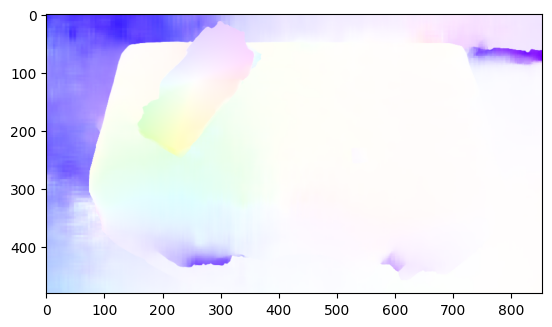

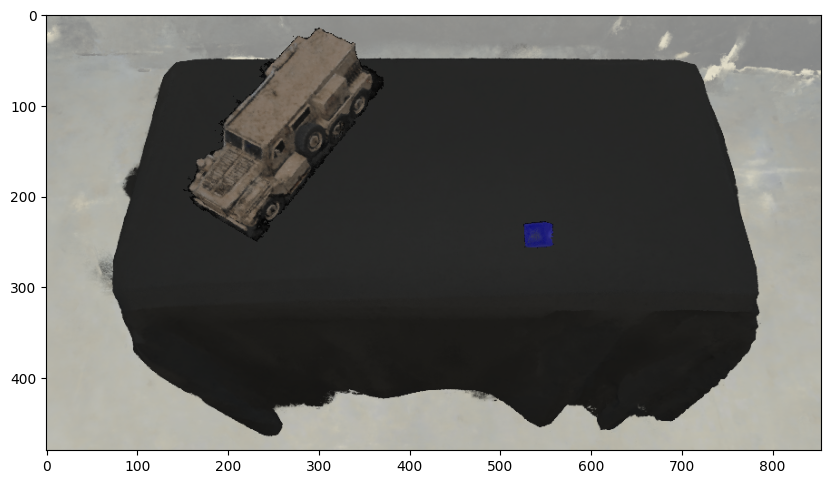

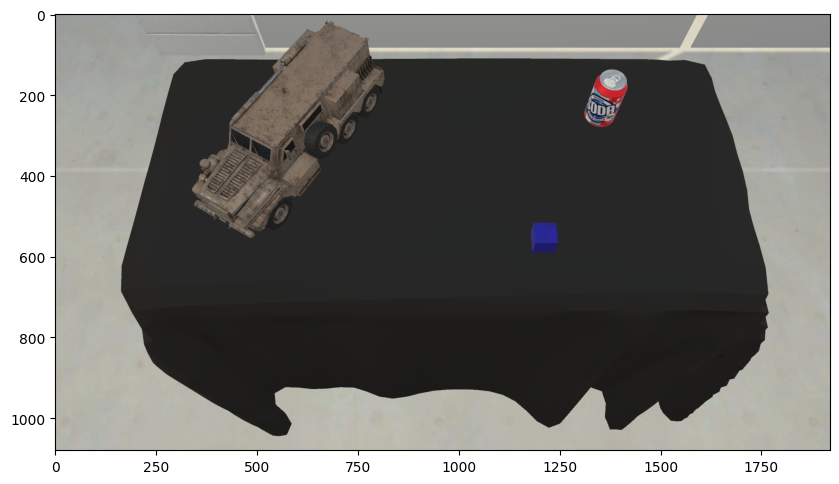

In [22]:
plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

_, _, _, image_composed, _ = network()
plt.figure(figsize=(10,6))
plt.imshow(image_composed)
plt.figure(figsize=(10,6))
plt.imshow(left/255)

In [ ]:
for obj in ['truck', 'block']: 
    testbed = testbed_map[obj]
    T_box = np.eye(4, 4)    
    T_box[0, 3] = testbed.crop_box()[1, 3]
    T_box[1, 3] = testbed.crop_box()[0, 3]
    T_box[2, 3] = testbed.crop_box()[2, 3]
    T = network.tf_nerf_cam[obj].cpu().numpy().astype(np.float64)
    tf_cam_world = network.tf_cam_world.cpu().numpy().astype(np.float64)
    T = tf_cam_world @ T @ T_box 
    T[:3, :3] = T[:3, :3].transpose() 
    send_tf(obj, T)
